In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from astroML import stats as astroMLstats
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from scipy import integrate, optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time
import dynesty
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

C:\Users\Admin\anaconda3\envs\Dynamics\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
T90=np.array(data[6],dtype=float)
fluence = np.array(data[9],dtype=float)
redshift = np.array(data[11],dtype=float)
condition = (T90 > 0) & (fluence > 0)
X = np.vstack((np.log10(T90[condition]), np.log10(fluence[condition]))).T
print(X)

[[-0.11463878 -6.24936049]
 [ 0.855398   -6.40652563]
 [ 1.35762997 -6.42776754]
 ...
 [ 0.49637605 -7.60453382]
 [ 2.31926433 -6.78225293]
 [ 0.71466499 -5.58410892]]


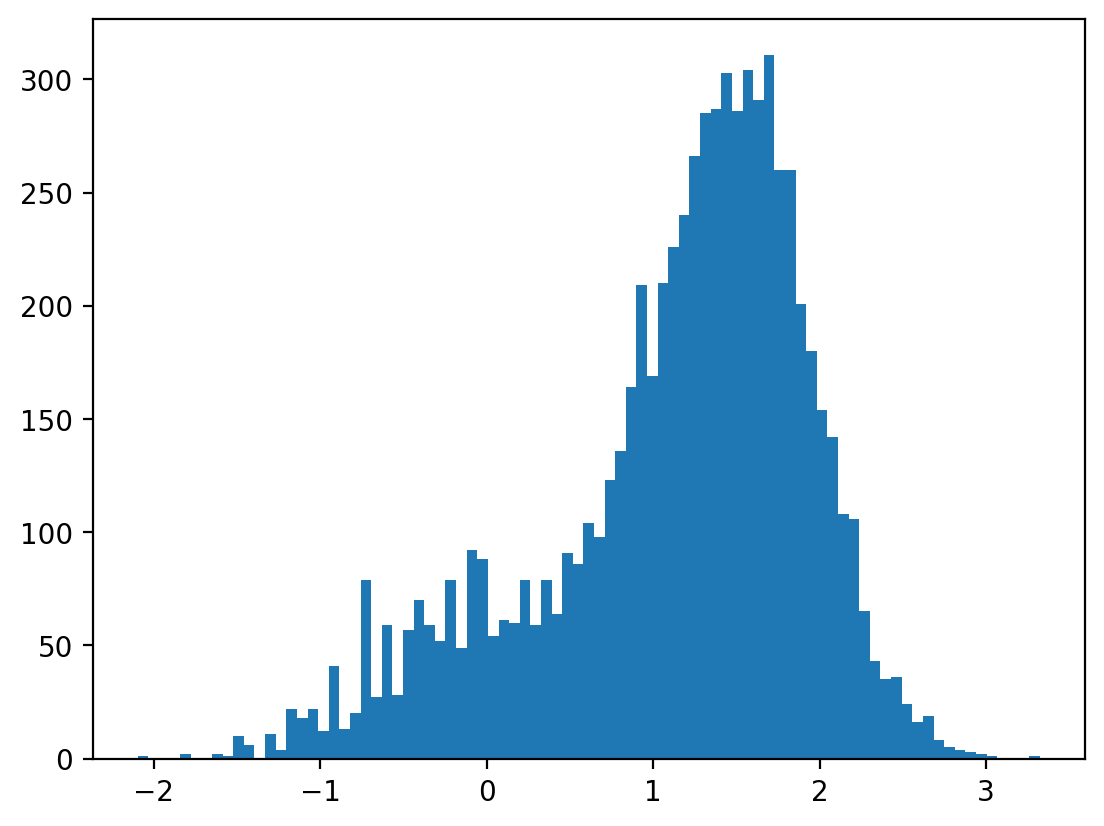

In [5]:
plt.hist(X[:,0], bins = int(np.sqrt(len(X))));

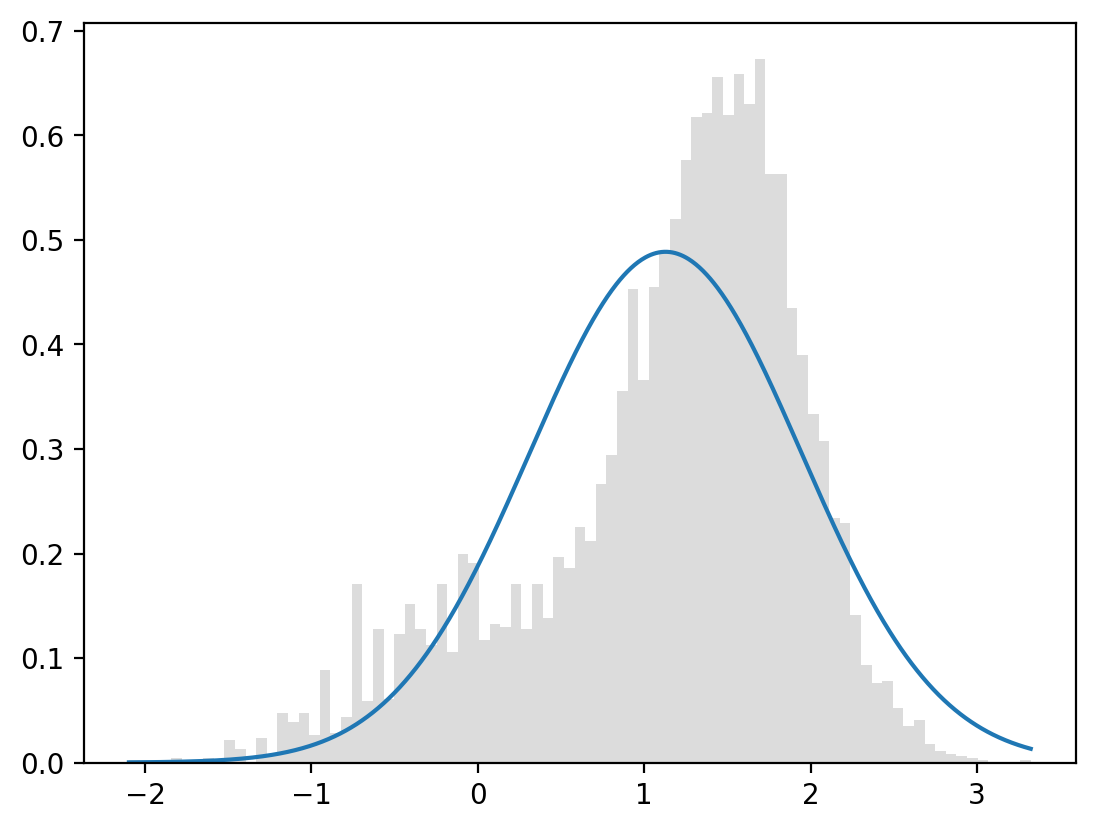

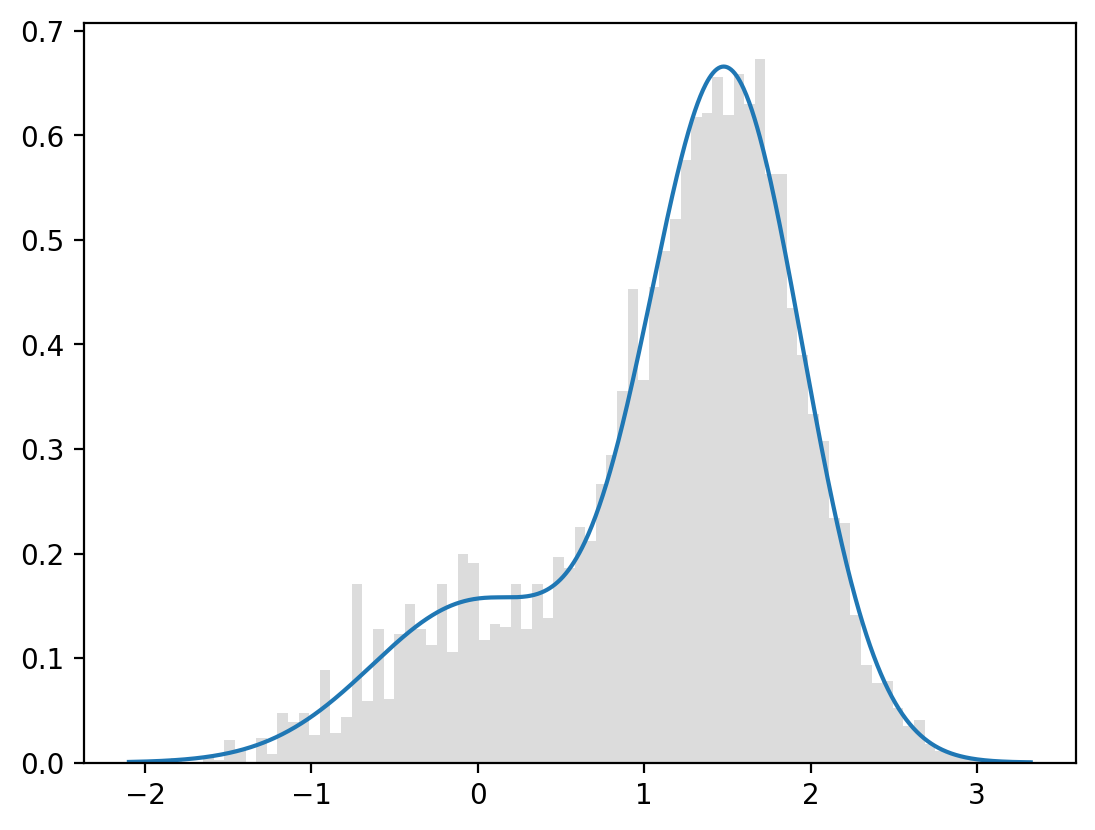

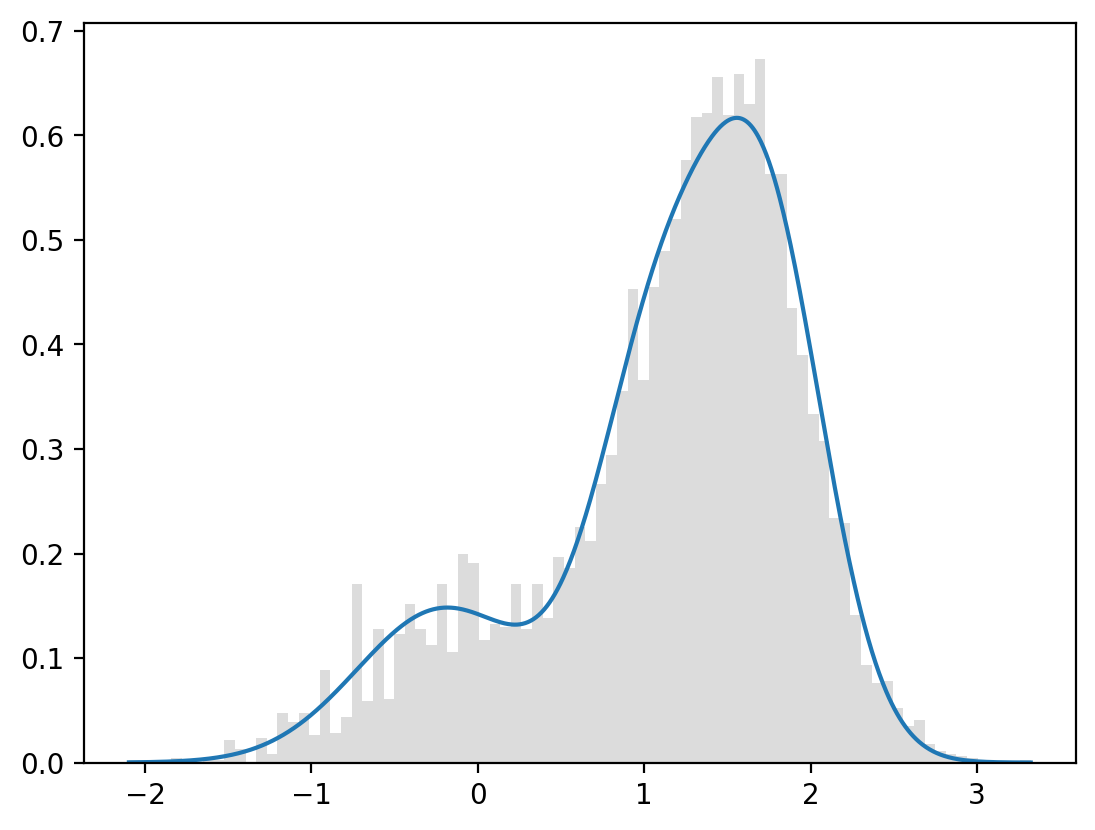

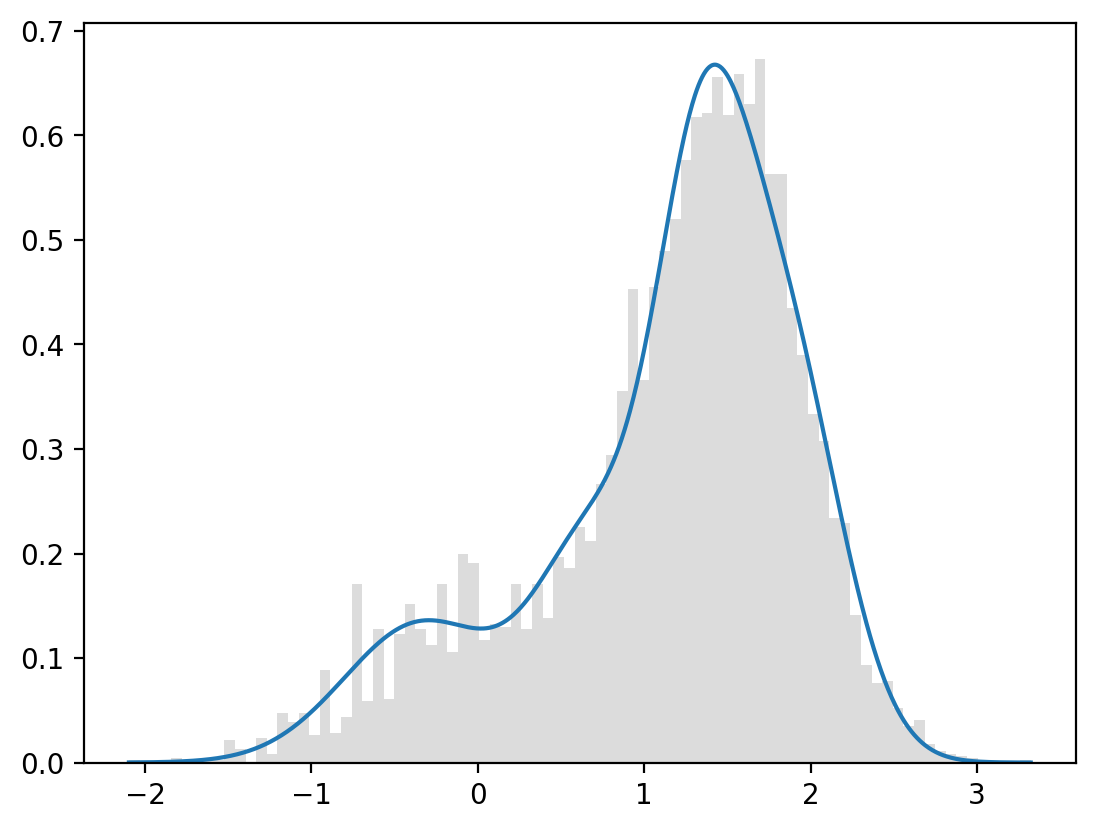

In [6]:
NvsAIC = np.zeros(shape = (4,2))

for n_comps in range(1,5):
    
    plt.hist(X[:,0], bins = int(np.sqrt(len(X))), density = True, color = 'gainsboro')
    
    x_fit = np.linspace(min(X[:,0]),max(X[:,0]),1000)
    
    gm = GaussianMixture(n_components = n_comps, covariance_type='diag', random_state=0).fit(X[:,0].reshape(-1, 1))
    
    log_L = gm.score_samples(x_fit.reshape(-1, 1)) #gives the logL of the sample
    pdf = np.exp(log_L)
    
    plt.plot(x_fit, pdf)
    
    NvsAIC[n_comps - 1] = [n_comps, gm.aic(X[:,0].reshape(-1, 1))]
    plt.show()

2.0


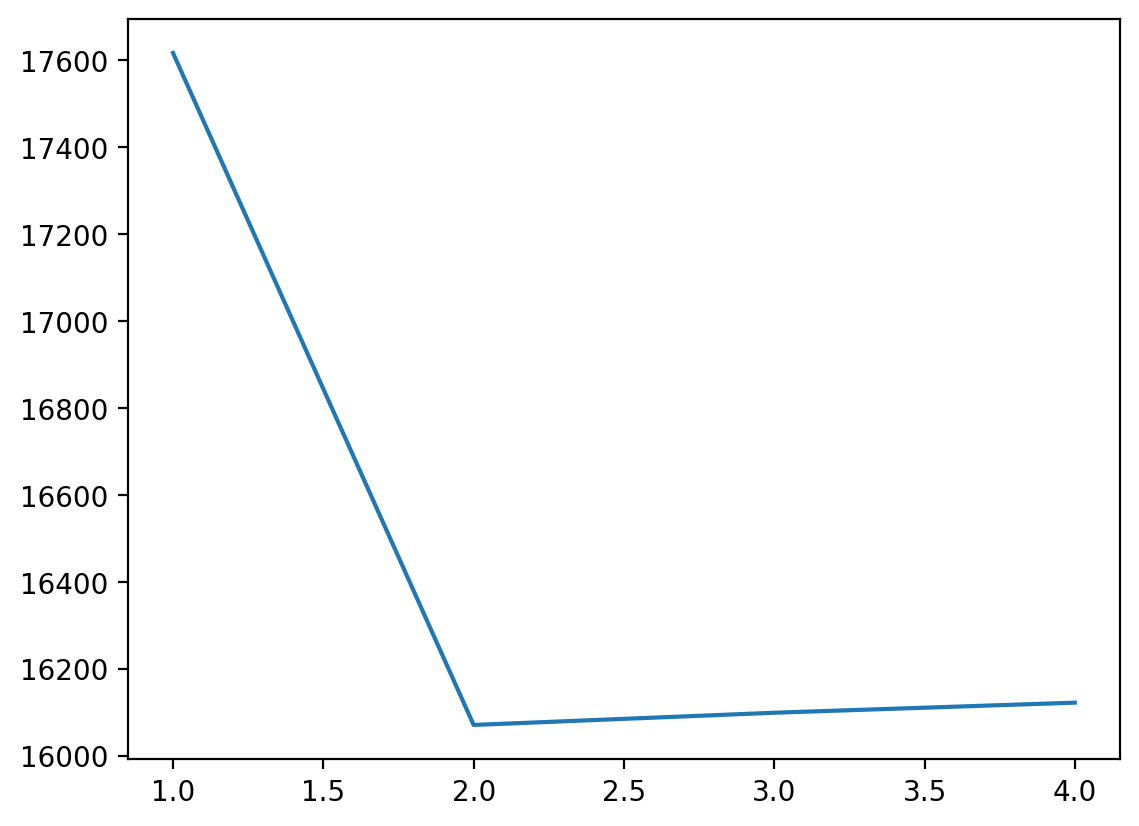

In [7]:
print(NvsAIC[:,0][np.argmin(NvsAIC[:,1])])
plt.plot(NvsAIC[:,0], NvsAIC[:,1])

Text(0.5, 0, 'T90')

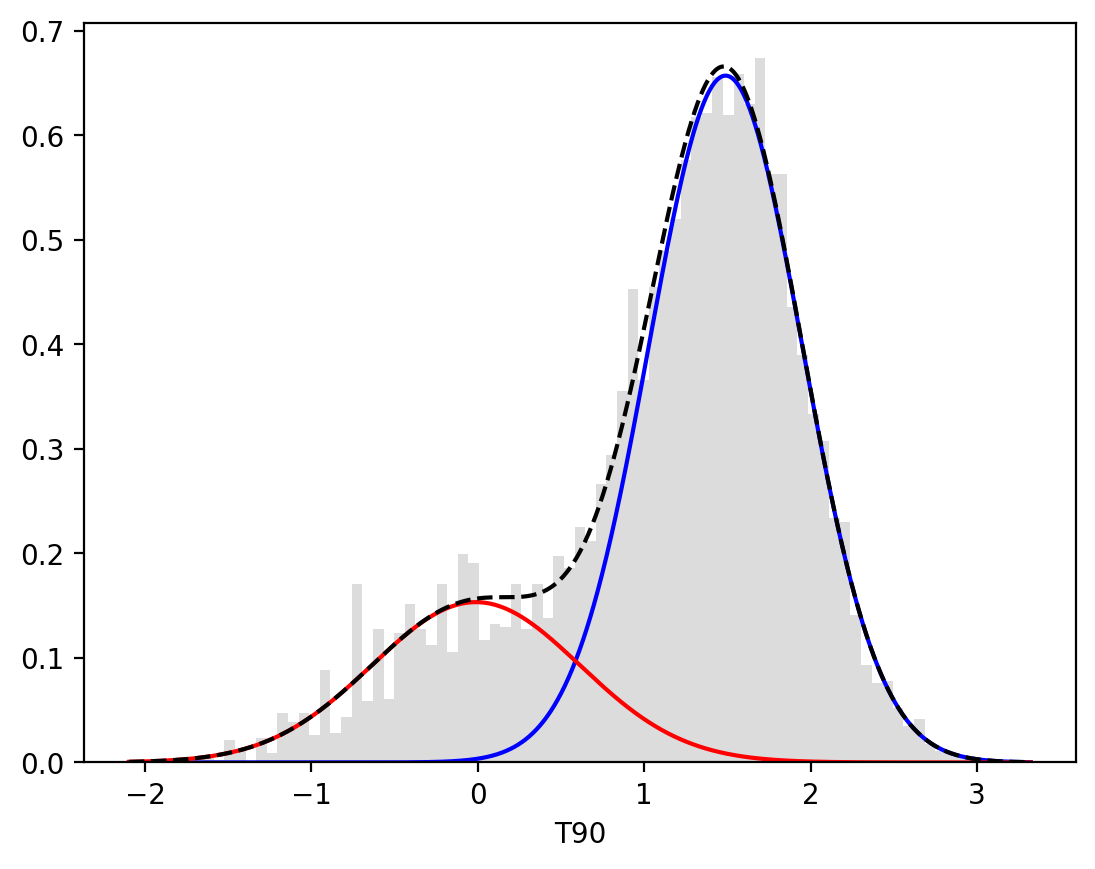

In [8]:
gm_good = GaussianMixture(n_components = 2, covariance_type='diag', random_state=0).fit(X[:,0].reshape(-1, 1))
plt.hist(X[:,0], bins = int(np.sqrt(len(X))), density = True, color = 'gainsboro')
log_L = gm_good.score_samples(x_fit.reshape(-1, 1))
pdf = np.exp(log_L)

resp = gm_good.predict_proba(x_fit.reshape(-1, 1)) #gives the probability of the components for each sample

component = resp * pdf[:, np.newaxis]

plt.plot(x_fit, component[:,0], c='blue')
plt.plot(x_fit, component[:,1], c='red')

plt.plot(x_fit, pdf, '--k')

plt.xlabel("T90")

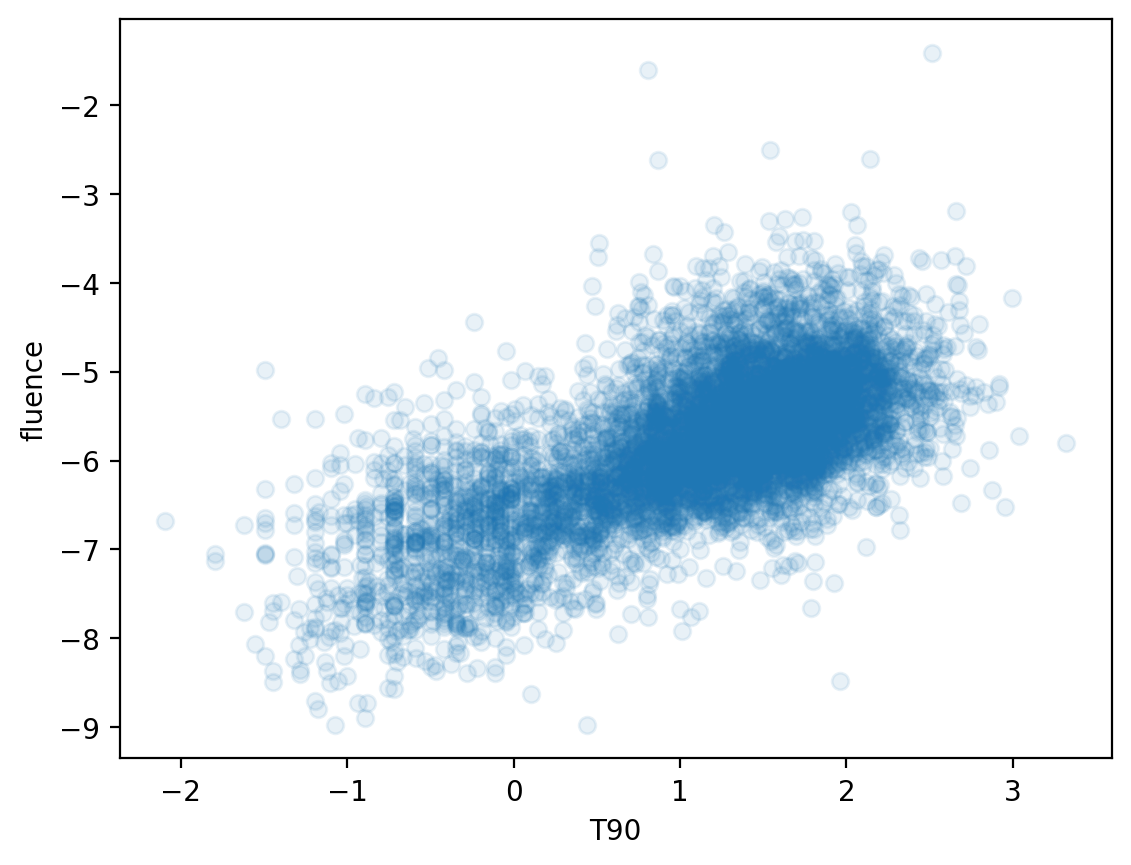

In [9]:
plt.xlabel("T90")
plt.ylabel("fluence")
plt.scatter(X[:,0], X[:,1], alpha = 0.1);

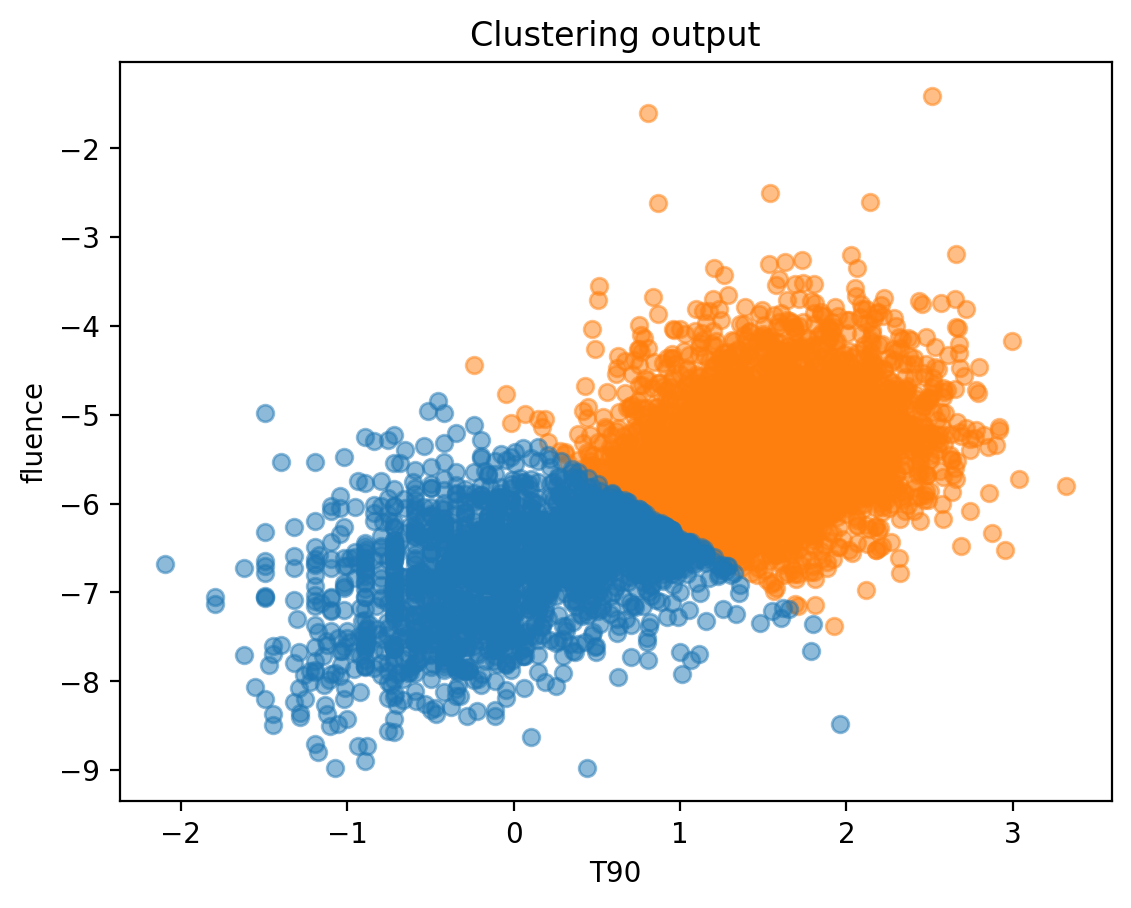

In [10]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=2) #Try 2 clusters to start with, but the number of clusters is an hyperparameter
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

# To get some information on these try:
# KMeans?
# help(clf)
plt.xlabel("T90")
plt.ylabel("fluence")
plt.title('Clustering output');

In [11]:
print(X[:,0])

[-0.11463878  0.855398    1.35762997 ...  0.49637605  2.31926433
  0.71466499]


In [14]:
n_clusters = 2
scaler = preprocessing.StandardScaler()
Y = scaler.fit_transform(X)
clf = KMeans(n_clusters, n_init = 'auto')
clf.fit(Y)
centers = clf.cluster_centers_

In [17]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

bandwidth = 0.4
#bandwidth = estimate_bandwidth(X) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False,
               seeds = centers)
ms.fit(Y)

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False,
          seeds=array([[-1.28480051, -1.124548  ],
       [ 0.49256822,  0.43113044]]))

[-1  0  1]
0.4
number of estimated clusters : 2


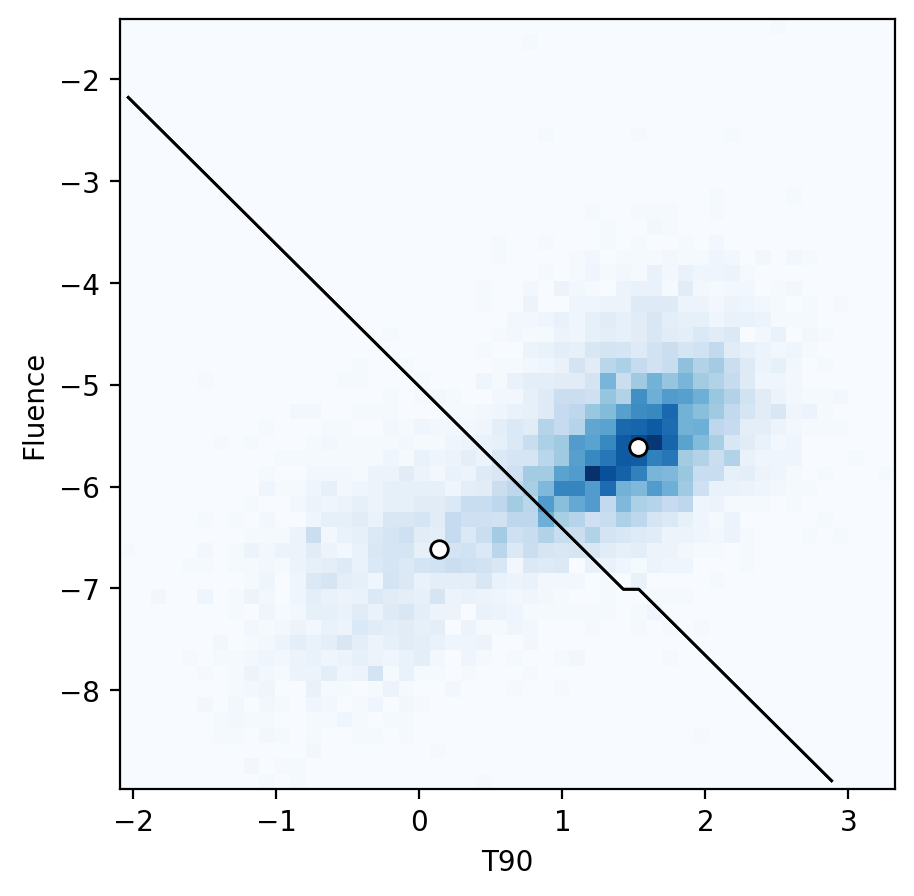

In [18]:
labels_unique = np.unique(ms.labels_)
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('Fluence')

plt.show()